<a href="https://colab.research.google.com/github/krugerleo/CDadosSeg/blob/master/projetoFinal/datascience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Autores:
##### [João Picolo](https://github.com/JoaoPicolo/CDadosSeg)
##### [Leonardo Krüger](https://github.com/krugerleo/CDadosSeg)
##### [Lucas Block](https://github.com/lucasvillatore/CDadosSeg)

### Algoritmos utilizados
- K-nearest neighbors
- Random Forests
- Multilayer perceptron

### Dataset Utilizado e informações
##### Foi utilizado o dataset relacionado a ataque de negação de serviço (DDoS) Esse dataset é disponibilizado nesse link: [ddos-dataset](https://www.kaggle.com/devendra416/ddos-datasets)
##### O dataset foi gerado e rotulado automaticamente utilizando [CICFlow](https://www.unb.ca/cic/research/applications.html#CICFlowMeter), desta forma é possível a extração de estatísticas sobre características de tráfico de rede.
Ele possui 170 colunas são divididas entre números inteiros, decimais e strings.
Nosso dataset é dividido entre dados que de fato fazem parte de um ataque DDoS e também dados Benignos, cada linha é pode ser identificada pela última coluna chamada "Label".

### Objetivo

Nosos objetivo nesse trabalho é utilizar essa base de dados para treinar uma rede artificial para predizer se determinado acesso faz parte de um ataque DDoS ou não. 

### Campos utilizados
- Timestamp
- Fwd Seg Size Min
- Source IP
- Dst IP
- Flow Iat Min
- Source Port
- Tot fwd Pkts
- Init Bwd Win Bytes


# Instalação

> Para execução correta:

1.   Deve montar o drive com a celula abaixo.
2.   O **final_dataset.csv** (nome deve ser igual) precisa estar na pasta raiz do drive.
3.   Para primeira execução não se existe dataset montado então essa opção será "não".
4.   Para futuras execuções é recomendado salvar os fragmentos do dataset que serão gerado e poder utilizar a opção de dataset montado.

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import's


In [ ]:
import sys

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt; plt.rcdefaults()
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, plot_roc_curve
from sklearn.utils import shuffle
from sklearn import preprocessing


# Definição de variáveis globais

In [ ]:
# Global variables
path = '/content/drive/MyDrive/'
columns_df = ['Timestamp', 'Fwd Seg Size Min', "Src IP", "Dst IP", 'Flow IAT Min', 'Src Port', 'Tot Fwd Pkts', 'Flow Duration', 'Label']

# Separação e montagem de dataframe
##### Funções utilizadas na instalação para montagem e criação dos dataframes

In [ ]:
def loadDatasets():
  global path, columns_df

  print("Loading datasets...")
  
  
  train_path_df = path + "train_dataset_phase_one.csv"
  train_df = pd.read_csv(
      train_path_df,
      usecols=columns_df
  )

  test_path_df = path + "test_dataset_phase_one.csv"
  test_df = pd.read_csv(
      test_path_df,
      usecols=columns_df
  )

  phase_one = {
      'train': train_df,
      'test': test_df
  }

  test_path_df = path + "test_dataset_phase_two.csv"
  test_df = pd.read_csv(
      test_path_df,
      usecols=columns_df
  )

  phase_two = {
      'test':test_df
  }

  print("Datasets recovered")

  return phase_one, phase_two


def mountDatasets():
  global path, columns_df

  print("Creating dataset...")
  path_df = path + "final_dataset.csv"

  data_frame = pd.read_csv(
      path_df,
      usecols=columns_df
  )
  data_frame.describe()
  # Separate df by type
  data_frame = shuffle(data_frame)
  ddos_df = data_frame.loc[data_frame['Label'] == 'ddos']
  benign_df = data_frame.loc[data_frame['Label'] == 'Benign']

  # Split dfs into training and test dfs
  eighty_ddos_percent, twenty_ddos_percent = train_test_split(ddos_df, test_size=0.2)
  eighty_ddos_percent, twenty_ddos_percent = train_test_split(twenty_ddos_percent, test_size=0.2)
  ddos_train, ddos_test = train_test_split(eighty_ddos_percent, test_size=0.2)
  
  
  eighty_benign_percent, twenty_benign_percent = train_test_split(benign_df, test_size=0.2)
  eighty_benign_percent, twenty_benign_percent = train_test_split(twenty_benign_percent, test_size=0.2)
  benign_train, benign_test = train_test_split(eighty_benign_percent, test_size=0.2)

  # Concatenate dataframes for train and test 80% percent
  train_df = pd.concat([ddos_train, benign_train])
  test_df = pd.concat([ddos_test, benign_test])
  
  phase_two_test = pd.concat([twenty_ddos_percent, twenty_benign_percent])
  print("Dataset created")

  # phase one
  phase_one = {
      'train': train_df,
      'test': test_df
  }

  phase_two = {
      'test': phase_two_test
  }

  return phase_one, phase_two, 


def saveDatasets(phase_one, phase_two):
  global path

  print("Saving datasets...")

  phase_one['train'].to_csv(path + "train_dataset_phase_one.csv", index=False)
  phase_one['test'].to_csv(path + "test_dataset_phase_one.csv", index=False)

  phase_two['test'].to_csv(path + "test_dataset_phase_two.csv", index=False)

  print("Datasets saved")

In [ ]:
use_mounted = input("Use mounted dataset? [y/n] ")

if(use_mounted.lower() == 'y'):
  phase_one, phase_two = loadDatasets()
else:
  phase_one, phase_two = mountDatasets()
  
  save_df = input("Save created datasets? [y/n]")
  
  if(save_df.lower() == 'y'):
    saveDatasets(phase_one, phase_two)




Use mounted dataset? [y/n] n
Creating dataset...
Dataset created
Save created datasets? [y/n]y
Saving datasets...
Datasets saved


# Dataframes
Utilizamos 20% do dataset separados em fase-1 = 16% e fase-2 = 4%

**train_df_one:** Porcentagem para treino -> 80% de 16% do dataset original  
**test_df_one:** Porcentagem para teste -> 20% de 16% do dataset original  
**test_df_two:** Porcentagem para teste na segunda fase -> 4% do dataset original  

In [ ]:
train_df_one = phase_one['train']
test_df_one = phase_one['test']
test_df_two = phase_two['test'] 

# Distribuição dataframes
  Distribuição dos dataframes de teste e treino pelo label ["ddos", "Benign"]

## 1 Treino

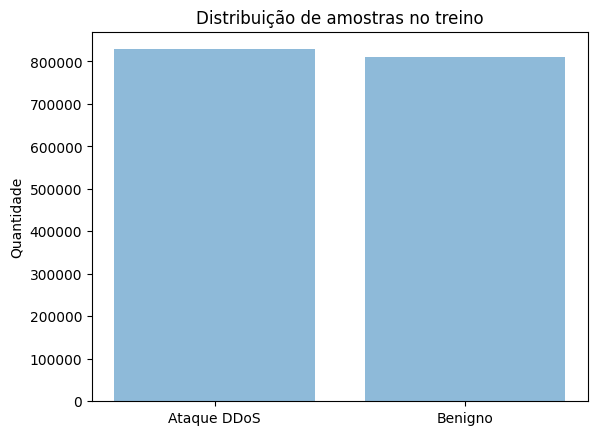

In [ ]:
ddos_df = train_df_one.loc[train_df_one['Label'] == 'ddos']
benign_df = train_df_one.loc[train_df_one['Label'] == 'Benign']

objects = ("Ataque DDoS", "Benigno")
y_pos = np.arange(len(objects))
distribution = [len(ddos_df), len(benign_df)]

plt.bar(y_pos, distribution, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Quantidade')
plt.title('Distribuição de amostras no treino')
plt.show()

## 2 Teste

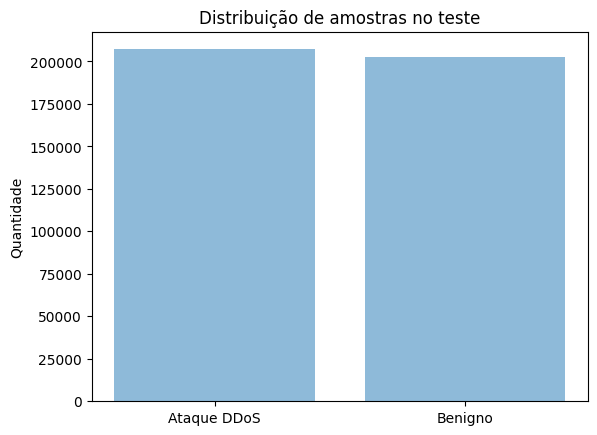

In [ ]:
ddos_df = test_df_one.loc[test_df_one['Label'] == 'ddos']
benign_df = test_df_one.loc[test_df_one['Label'] == 'Benign']

objects = ("Ataque DDoS", "Benigno")
y_pos = np.arange(len(objects))
distribution = [len(ddos_df), len(benign_df)]

plt.bar(y_pos, distribution, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Quantidade')
plt.title('Distribuição de amostras no teste')
plt.show()

## 3 Teste (Porção 2)

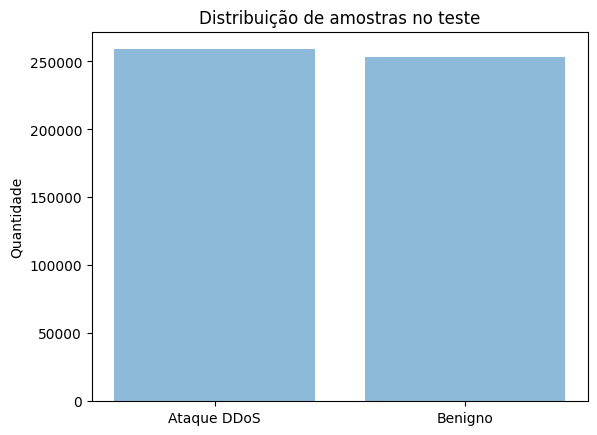

,Src IP,Src Port,Dst IP,Timestamp,Flow Duration,Tot Fwd Pkts,Flow IAT Min,Fwd Seg Size Min,Label
928966,18.218.55.126,54765,172.31.69.28,22/02/2018 12:09:51 AM,1546,1,1546.0,0,ddos
4419659,18.219.193.20,59360,172.31.69.25,16/02/2018 11:26:12 PM,911,1,911.0,0,ddos
3491287,18.219.193.20,51432,172.31.69.25,16/02/2018 11:19:16 PM,2595,1,2595.0,0,ddos
3838680,18.219.193.20,43884,172.31.69.25,16/02/2018 11:21:50 PM,4719,1,4719.0,0,ddos
3690955,18.219.193.20,52014,172.31.69.25,16/02/2018 11:20:44 PM,36726,1,36726.0,0,ddos
...,...,...,...,...,...,...,...,...,...
7661031,172.31.67.86,51143,23.46.62.134,20/02/2018 01:02:44,118601,9,1.0,20,Benign
10254063,172.31.68.11,49674,13.89.187.212,20/02/2018 02:32:23,60091282,4,30756.0,20,Benign
7834008,172.31.66.119,445,190.78.159.76,20/02/2018 02:17:06,26,2,26.0,20,Benign
10588346,172.31.67.42,49997,172.31.0.2,20/02/2018 03:04:25,1007,1,1007.0,8,Benign


In [ ]:
ddos_df = test_df_two.loc[test_df_two['Label'] == 'ddos']
benign_df = test_df_two.loc[test_df_two['Label'] == 'Benign']

objects = ("Ataque DDoS", "Benigno")
y_pos = np.arange(len(objects))
distribution = [len(ddos_df), len(benign_df)]

plt.bar(y_pos, distribution, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Quantidade')
plt.title('Distribuição de amostras no teste')
plt.show()

#  Algoritmos
 Utilizados com cross validation k-folders = 5
1.   K-nearest neighbors
2.   Random Forests
3.   Multilayer perceptron




## 1.1 KNeighbors

Para esse classificador utilizamos N-Neighbors = 5


Executing KNN classification
[[155535  46769]
 [199336   7789]]
0.6010932298396059
              precision    recall  f1-score   support

           0       0.44      0.77      0.56    202304
           1       0.14      0.04      0.06    207125

    accuracy                           0.40    409429
   macro avg       0.29      0.40      0.31    409429
weighted avg       0.29      0.40      0.31    409429



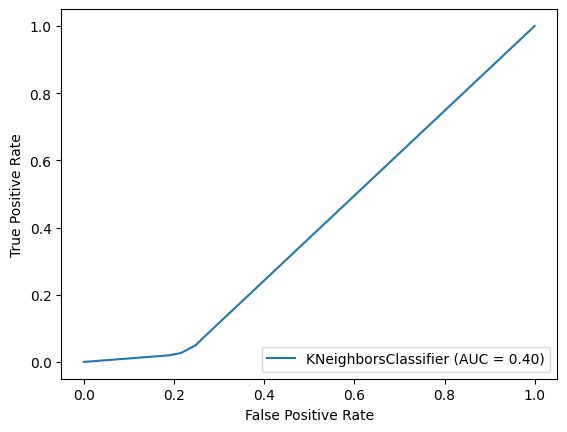

In [ ]:
print("Executing KNN classification")

fit_train = train_df_one.apply(LabelEncoder().fit_transform)
fit_test = test_df_one.apply(LabelEncoder().fit_transform)

n_columns = len(fit_train.columns)

x_train = fit_train.iloc[:, :-1].values # Features ?
y_train = fit_train.iloc[:, n_columns-1].values # (n_columns-1) = Labels

x_test = fit_test.iloc[:, :-1].values # Features ?
y_test = fit_test.iloc[:, n_columns-1].values # (n_columns-1) = Labels

# Executes algorithm
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_roc_curve(classifier, x_test, y_test)

## 1.2 KNeighbors cross validation

Cross validating KNNN
[[161247    596]
 [   184 165516]]
0.00238136672131598
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    161843
           1       1.00      1.00      1.00    165700

    accuracy                           1.00    327543
   macro avg       1.00      1.00      1.00    327543
weighted avg       1.00      1.00      1.00    327543

[[161267    575]
 [   198 165502]]
0.0023600026866783495
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    161842
           1       1.00      1.00      1.00    165700

    accuracy                           1.00    327542
   macro avg       1.00      1.00      1.00    327542
weighted avg       1.00      1.00      1.00    327542

[[161216    626]
 [   182 165518]]
0.002466859211948391
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    161842
           1       1.00      1.00      1.00    

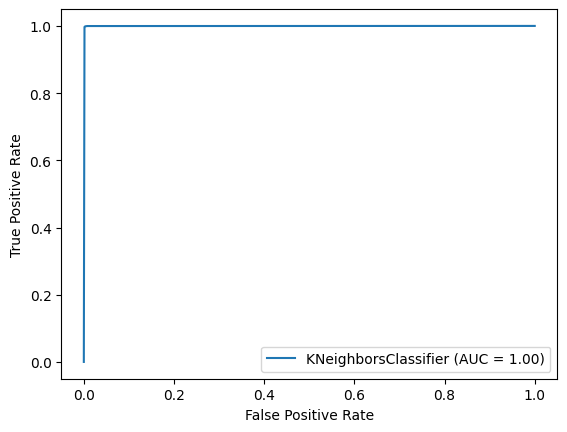

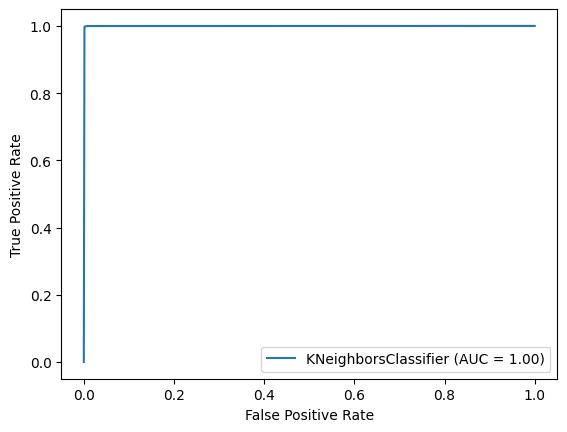

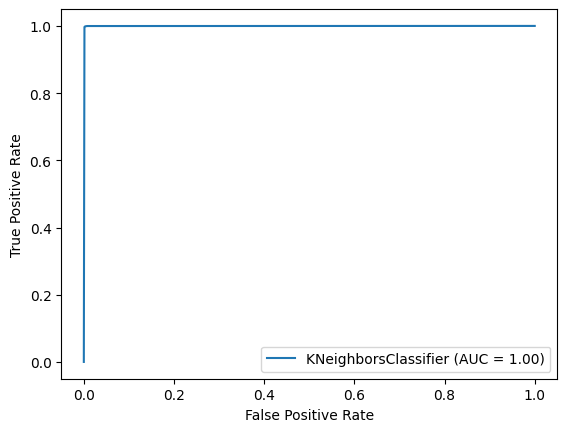

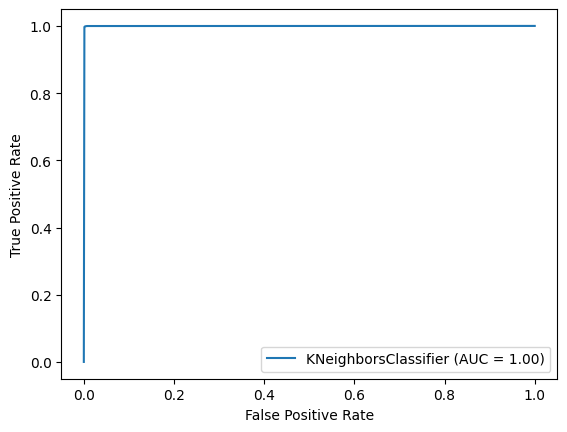

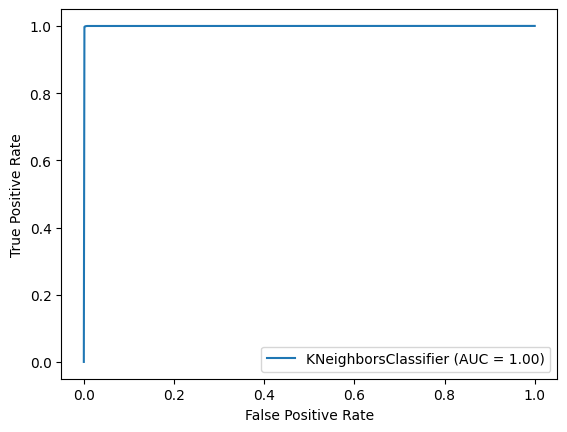

In [ ]:
print("Cross validating KNNN")

fit_train = train_df_one.apply(LabelEncoder().fit_transform)

n_columns = len(fit_train.columns)
x = fit_train.iloc[:, :-1].values # Features
y = fit_train.iloc[:, n_columns-1].values # Labels


kf = StratifiedKFold(n_splits=5)

for train_index, test_index in kf.split(x, y):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]

  classifier = KNeighborsClassifier(n_neighbors=5)
  classifier.fit(x_train, y_train)
  y_pred = classifier.predict(x_test)


  print(confusion_matrix(y_test, y_pred))
  print(mean_absolute_error(y_test, y_pred))
  print(classification_report(y_test, y_pred))   
  plot_roc_curve(classifier, x_test, y_test)

## 1.3 KNeighbors (Porção 2)

Executing KNN classification
[[200339  52541]
 [210010  48896]]
0.5130093437491452
              precision    recall  f1-score   support

           0       0.49      0.79      0.60    252880
           1       0.48      0.19      0.27    258906

    accuracy                           0.49    511786
   macro avg       0.49      0.49      0.44    511786
weighted avg       0.49      0.49      0.44    511786



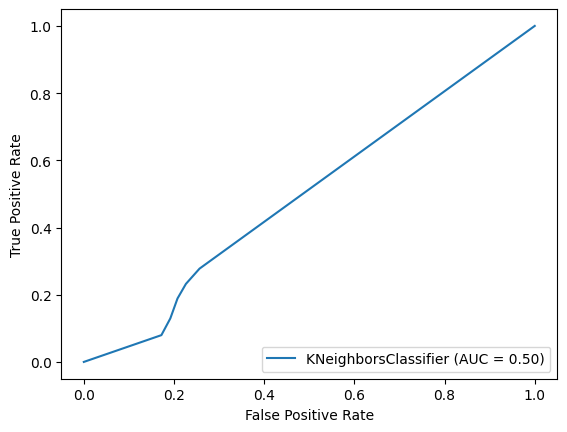

In [ ]:
print("Executing KNN classification")

fit_train = train_df_one.apply(LabelEncoder().fit_transform)
fit_test = test_df_two.apply(LabelEncoder().fit_transform)

n_columns = len(fit_train.columns)

x_train = fit_train.iloc[:, :-1].values # Features ?
y_train = fit_train.iloc[:, n_columns-1].values # (n_columns-1) = Labels

x_test = fit_test.iloc[:, :-1].values # Features ?
y_test = fit_test.iloc[:, n_columns-1].values # (n_columns-1) = Labels

# Executes algorithm
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_roc_curve(classifier, x_test, y_test)

## 1.4 KNeighbors cross validation (Porção 2)

Cross validating KNNN
[[50261   315]
 [   82 51700]]
0.0038785439340354444
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     50576
           1       0.99      1.00      1.00     51782

    accuracy                           1.00    102358
   macro avg       1.00      1.00      1.00    102358
weighted avg       1.00      1.00      1.00    102358

[[50300   276]
 [   74 51707]]
0.0034194046328047912
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     50576
           1       0.99      1.00      1.00     51781

    accuracy                           1.00    102357
   macro avg       1.00      1.00      1.00    102357
weighted avg       1.00      1.00      1.00    102357

[[50268   308]
 [   89 51692]]
0.003878581826352863
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     50576
           1       0.99      1.00      1.00     51781

  

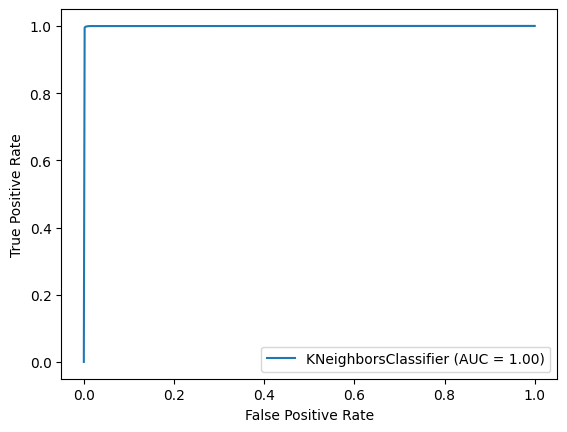

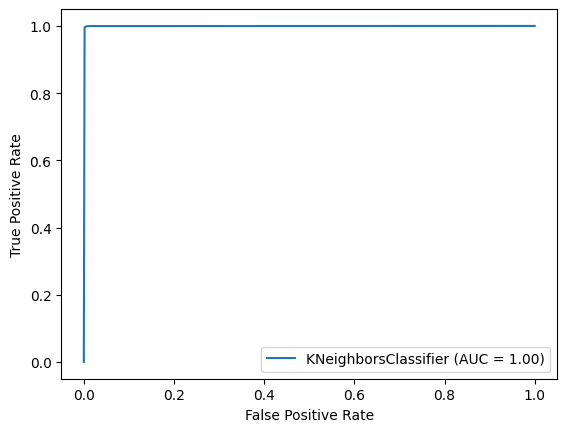

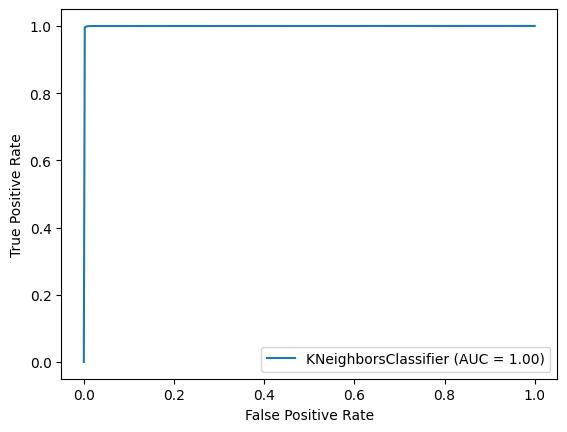

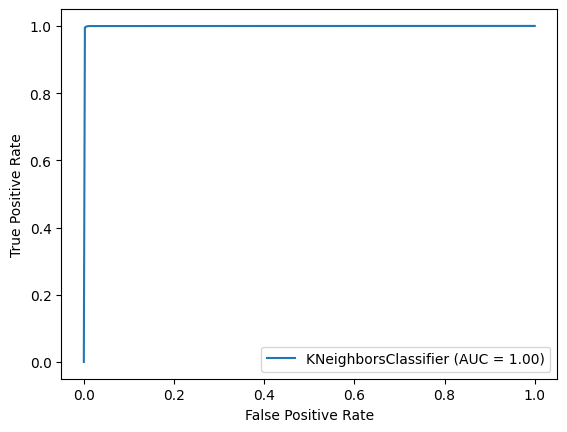

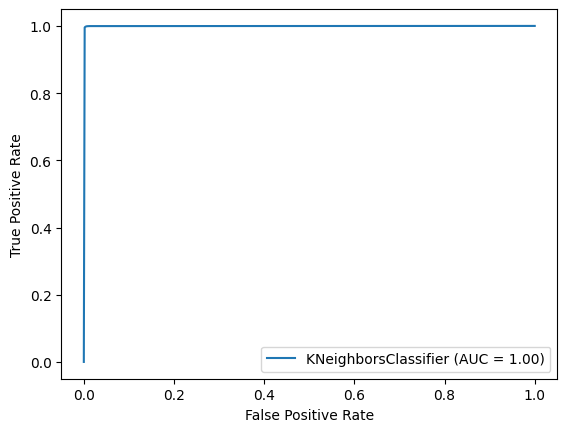

In [ ]:
print("Cross validating KNNN")

fit_train = test_df_two.apply(LabelEncoder().fit_transform)

n_columns = len(fit_train.columns)
x = fit_train.iloc[:, :-1].values # Features
y = fit_train.iloc[:, n_columns-1].values # Labels


kf = StratifiedKFold(n_splits=5)

for train_index, test_index in kf.split(x, y):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]

  classifier = KNeighborsClassifier(n_neighbors=5)
  classifier.fit(x_train, y_train)
  y_pred = classifier.predict(x_test)


  print(confusion_matrix(y_test, y_pred))
  print(mean_absolute_error(y_test, y_pred))
  print(classification_report(y_test, y_pred))   
  plot_roc_curve(classifier, x_test, y_test)

## 2.1 Random forests

Para esse classificador utilizamos n_estimators = 50

Executing Random Forest classification
[[202304      0]
 [207125      0]]
0.505887467668387


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.49      1.00      0.66    202304
           1       0.00      0.00      0.00    207125

    accuracy                           0.49    409429
   macro avg       0.25      0.50      0.33    409429
weighted avg       0.24      0.49      0.33    409429



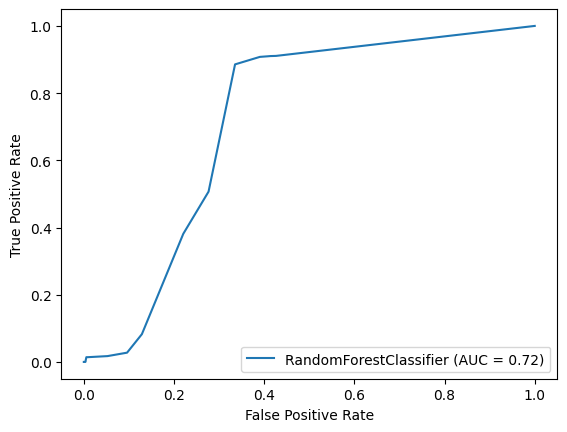

In [ ]:
print("Executing Random Forest classification")

fit_train = train_df_one.apply(LabelEncoder().fit_transform)
fit_test = test_df_one.apply(LabelEncoder().fit_transform)

n_columns = len(fit_train.columns)

x_train = fit_train.iloc[:, :-1].values # Features
y_train = fit_train.iloc[:, n_columns-1].values # Labels

x_test = fit_test.iloc[:, :-1].values # Features
y_test = fit_test.iloc[:, n_columns-1].values # Labels

classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_roc_curve(classifier, x_test, y_test)

## 2.2 Random forests cross validation

Cross validating Random Forest
Fold 1

[[161843      0]
 [     0 165700]]
0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    161843
           1       1.00      1.00      1.00    165700

    accuracy                           1.00    327543
   macro avg       1.00      1.00      1.00    327543
weighted avg       1.00      1.00      1.00    327543

Fold 2

[[161842      0]
 [     1 165699]]
3.0530435791440486e-06
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    161842
           1       1.00      1.00      1.00    165700

    accuracy                           1.00    327542
   macro avg       1.00      1.00      1.00    327542
weighted avg       1.00      1.00      1.00    327542

Fold 3

[[161842      0]
 [     0 165700]]
0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    161842
           1       1.00      1.00      1.00   

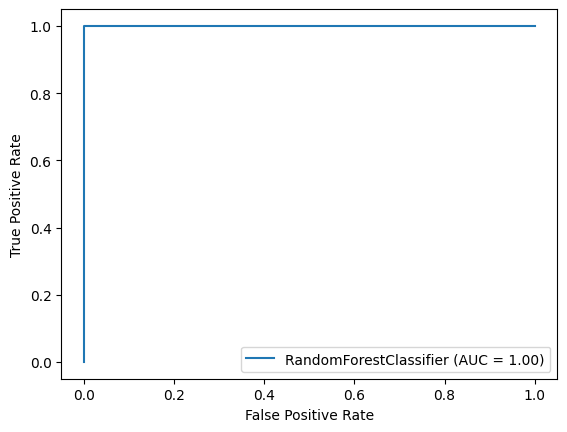

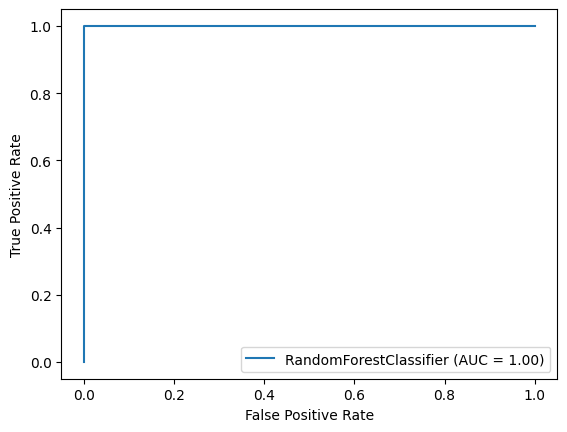

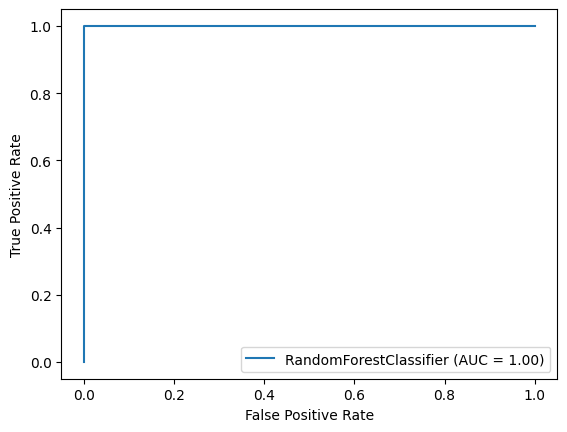

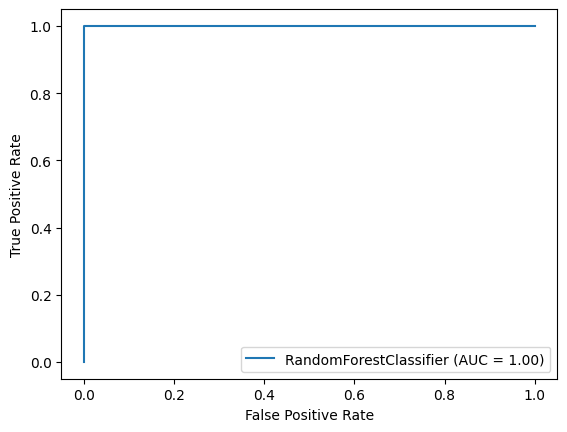

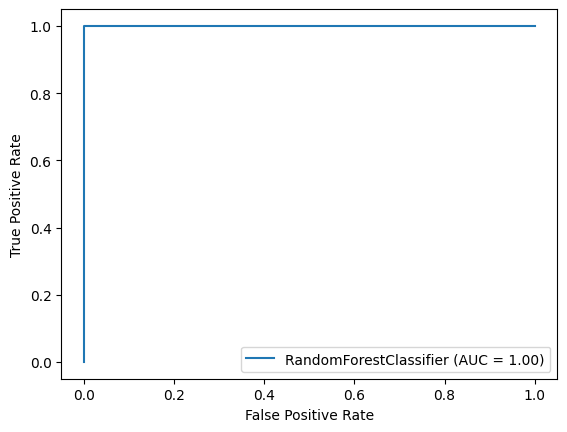

In [ ]:
print("Cross validating Random Forest")

fit_train = train_df_one.apply(LabelEncoder().fit_transform)

n_columns = len(fit_train.columns)
x = fit_train.iloc[:, :-1].values # Features
y = fit_train.iloc[:, n_columns-1].values # Labels

idx = 0
kf = StratifiedKFold(n_splits=5)

for train_index, test_index in kf.split(x, y):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  idx += 1
  print(f"Fold {idx}\n")


  classifier = RandomForestClassifier(n_estimators=50)
  classifier.fit(x_train, y_train)
  y_pred = classifier.predict(x_test)

  print(confusion_matrix(y_test, y_pred))
  print(mean_absolute_error(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  plot_roc_curve(classifier, x_test, y_test)

## 2.3 Random Forests (Porção 2)

Executing Random Forest classification
[[252880      0]
 [258906      0]]
0.5058872263016183


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.49      1.00      0.66    252880
           1       0.00      0.00      0.00    258906

    accuracy                           0.49    511786
   macro avg       0.25      0.50      0.33    511786
weighted avg       0.24      0.49      0.33    511786



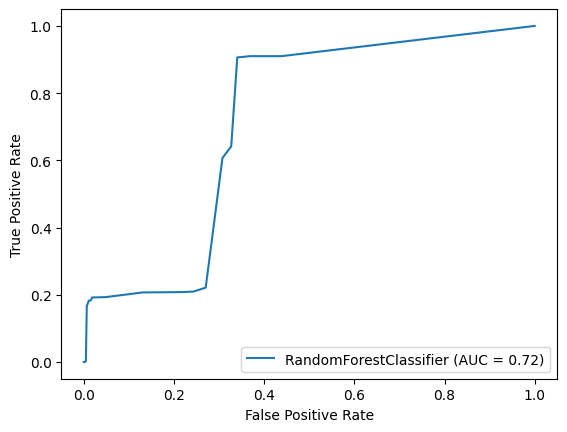

In [ ]:
print("Executing Random Forest classification")

fit_train = train_df_one.apply(LabelEncoder().fit_transform)
fit_test = test_df_two.apply(LabelEncoder().fit_transform)

n_columns = len(fit_train.columns)

x_train = fit_train.iloc[:, :-1].values # Features
y_train = fit_train.iloc[:, n_columns-1].values # Labels

x_test = fit_test.iloc[:, :-1].values # Features
y_test = fit_test.iloc[:, n_columns-1].values # Labels

classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_roc_curve(classifier, x_test, y_test)

## 2.4 Random Forests Cross Validation (Porção 2)

Cross validating Random Forest
Fold 1

[[50576     0]
 [    0 51782]]
0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50576
           1       1.00      1.00      1.00     51782

    accuracy                           1.00    102358
   macro avg       1.00      1.00      1.00    102358
weighted avg       1.00      1.00      1.00    102358

Fold 2

[[50576     0]
 [    0 51781]]
0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50576
           1       1.00      1.00      1.00     51781

    accuracy                           1.00    102357
   macro avg       1.00      1.00      1.00    102357
weighted avg       1.00      1.00      1.00    102357

Fold 3

[[50576     0]
 [    0 51781]]
0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50576
           1       1.00      1.00      1.00     51781

    accuracy          

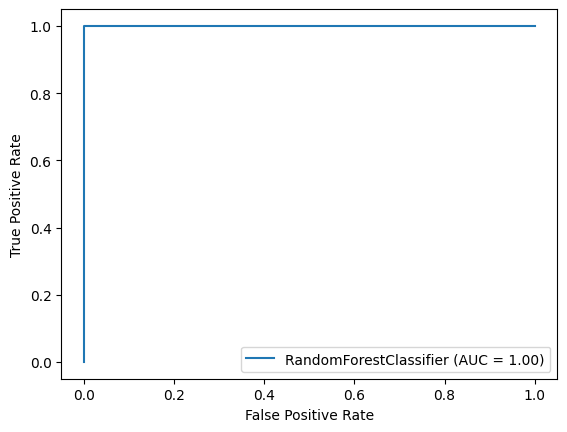

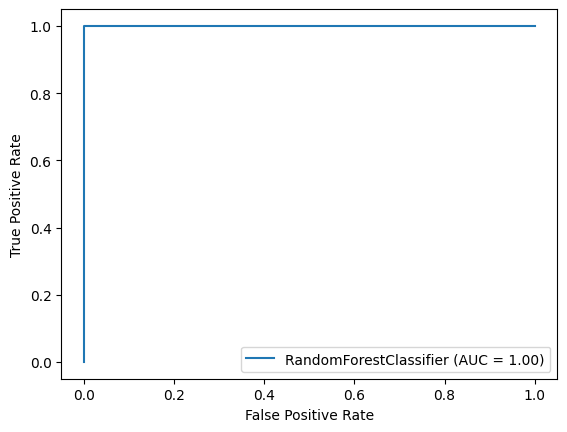

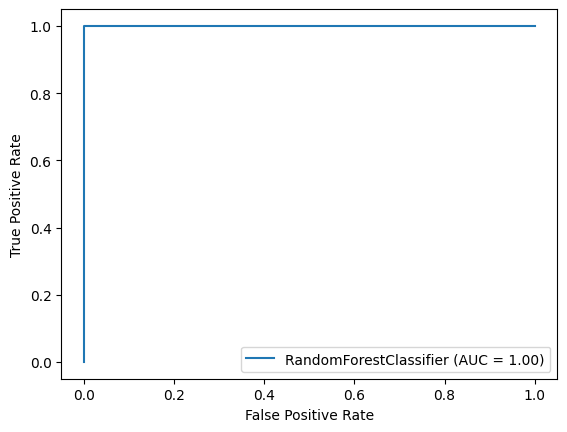

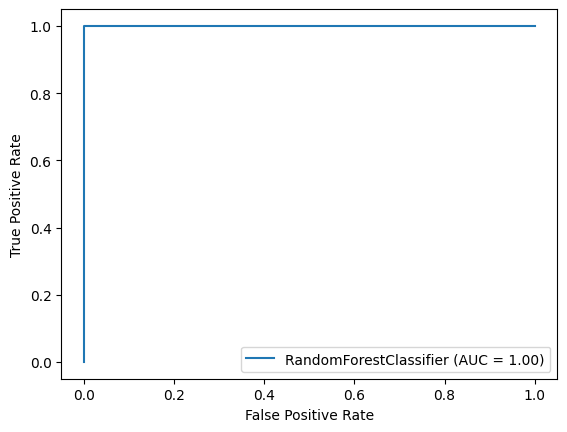

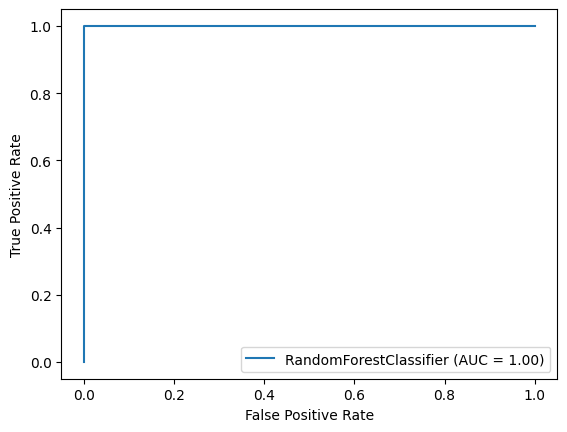

In [ ]:
print("Cross validating Random Forest")

fit_train = test_df_two.apply(LabelEncoder().fit_transform)

n_columns = len(fit_train.columns)
x = fit_train.iloc[:, :-1].values # Features
y = fit_train.iloc[:, n_columns-1].values # Labels

idx = 0
kf = StratifiedKFold(n_splits=5)

for train_index, test_index in kf.split(x, y):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  idx += 1
  print(f"Fold {idx}\n")


  classifier = RandomForestClassifier(n_estimators=50)
  classifier.fit(x_train, y_train)
  y_pred = classifier.predict(x_test)

  print(confusion_matrix(y_test, y_pred))
  print(mean_absolute_error(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  plot_roc_curve(classifier, x_test, y_test)

## 3.1 Multilayer perceptron

Para esse classificador utilizamos hidden_layer_sizes = 6

Executing MLP classification
[[ 25813 176491]
 [   579 206546]]
0.4324803567895777
              precision    recall  f1-score   support

           0       0.98      0.13      0.23    202304
           1       0.54      1.00      0.70    207125

    accuracy                           0.57    409429
   macro avg       0.76      0.56      0.46    409429
weighted avg       0.76      0.57      0.47    409429



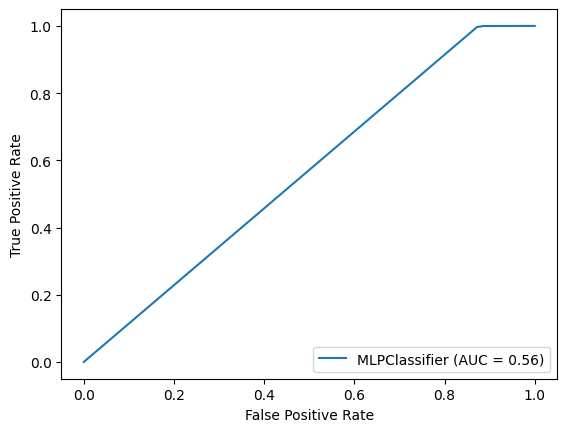

In [ ]:
print("Executing MLP classification")

fit_train = train_df_one.apply(LabelEncoder().fit_transform)
fit_test = test_df_one.apply(LabelEncoder().fit_transform)

n_columns = len(fit_train.columns)

x_train = fit_train.iloc[:, :-1].values # Features
y_train = fit_train.iloc[:, n_columns-1].values # Labels

x_test = fit_test.iloc[:, :-1].values # Features
y_test = fit_test.iloc[:, n_columns-1].values # Labels

# Executes algorithm
classifier = MLPClassifier(hidden_layer_sizes=6)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_roc_curve(classifier, x_test, y_test)


## 3.2 Multilayer perceptron cross validation

Cross validating MLP
Fold 1



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[[154224   7619]
 [ 12594 153106]]
0.06171098145892295
              precision    recall  f1-score   support

           0       0.92      0.95      0.94    161843
           1       0.95      0.92      0.94    165700

    accuracy                           0.94    327543
   macro avg       0.94      0.94      0.94    327543
weighted avg       0.94      0.94      0.94    327543

Fold 2



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[[153986   7856]
 [  3863 161837]]
0.03577861770398911
              precision    recall  f1-score   support

           0       0.98      0.95      0.96    161842
           1       0.95      0.98      0.97    165700

    accuracy                           0.96    327542
   macro avg       0.96      0.96      0.96    327542
weighted avg       0.96      0.96      0.96    327542

Fold 3



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[[156977   4865]
 [  4596 161104]]
0.028884845302281845
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    161842
           1       0.97      0.97      0.97    165700

    accuracy                           0.97    327542
   macro avg       0.97      0.97      0.97    327542
weighted avg       0.97      0.97      0.97    327542

Fold 4

[[ 40595 121247]
 [   776 164924]]
0.37254153665789425
              precision    recall  f1-score   support

           0       0.98      0.25      0.40    161842
           1       0.58      1.00      0.73    165700

    accuracy                           0.63    327542
   macro avg       0.78      0.62      0.56    327542
weighted avg       0.78      0.63      0.57    327542

Fold 5



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[[160136   1707]
 [ 18604 147095]]
0.062010368135994774
              precision    recall  f1-score   support

           0       0.90      0.99      0.94    161843
           1       0.99      0.89      0.94    165699

    accuracy                           0.94    327542
   macro avg       0.94      0.94      0.94    327542
weighted avg       0.94      0.94      0.94    327542



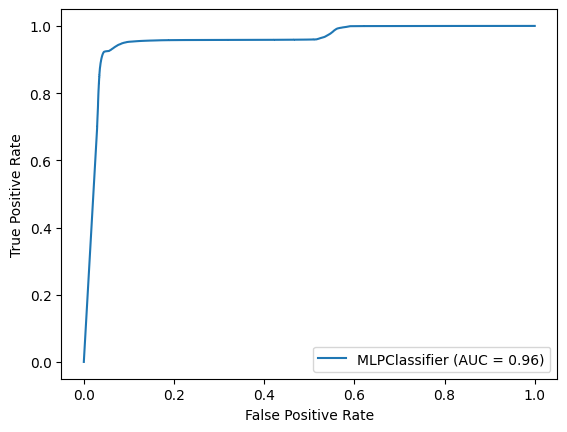

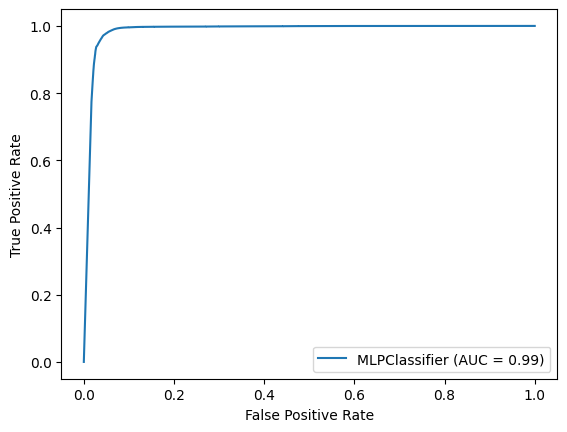

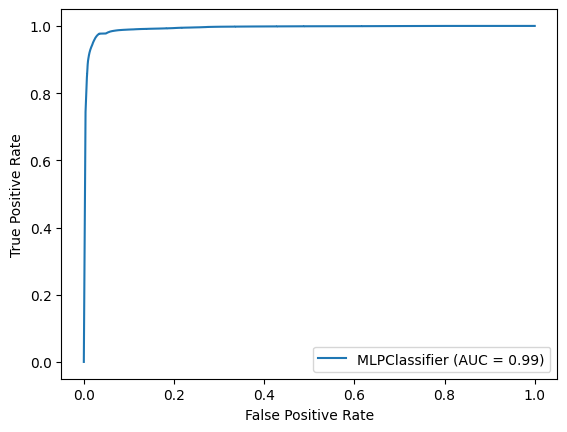

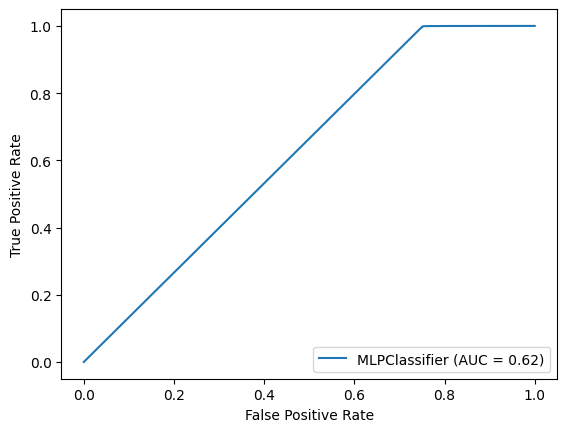

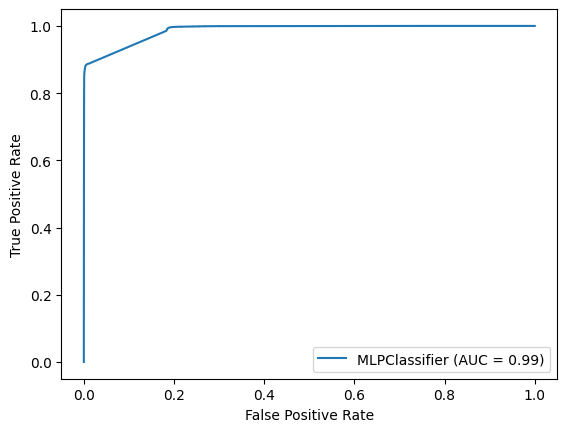

In [ ]:
print("Cross validating MLP")

fit_train = train_df_one.apply(LabelEncoder().fit_transform)

n_columns = len(fit_train.columns)
x = fit_train.iloc[:, :-1].values # Features
y = fit_train.iloc[:, n_columns-1].values # Labels

idx = 0
kf = StratifiedKFold(n_splits=5)

for train_index, test_index in kf.split(x, y):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  idx += 1
  print(f"Fold {idx}\n")


  classifier = MLPClassifier(hidden_layer_sizes=6)
  classifier.fit(x_train, y_train)
  y_pred = classifier.predict(x_test)

  print(confusion_matrix(y_test, y_pred))
  print(mean_absolute_error(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  plot_roc_curve(classifier, x_test, y_test)

## 3.3 Multilayer perceptron (Porção 2)

Executing MLP classification


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[[252738    142]
 [153198 105708]]
0.2996174182177707
              precision    recall  f1-score   support

           0       0.62      1.00      0.77    252880
           1       1.00      0.41      0.58    258906

    accuracy                           0.70    511786
   macro avg       0.81      0.70      0.67    511786
weighted avg       0.81      0.70      0.67    511786



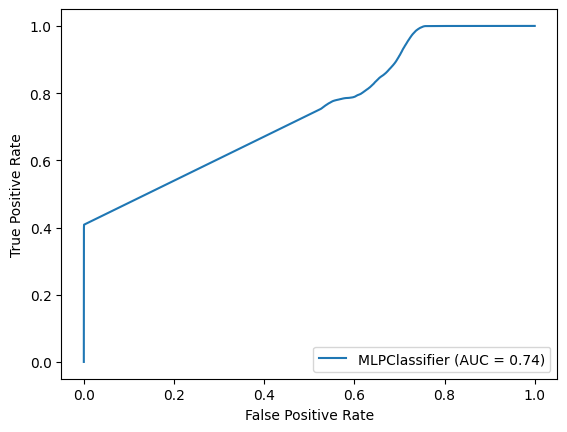

In [ ]:
print("Executing MLP classification")

fit_train = train_df_one.apply(LabelEncoder().fit_transform)
fit_test = test_df_two.apply(LabelEncoder().fit_transform)

n_columns = len(fit_train.columns)

x_train = fit_train.iloc[:, :-1].values # Features
y_train = fit_train.iloc[:, n_columns-1].values # Labels

x_test = fit_test.iloc[:, :-1].values # Features
y_test = fit_test.iloc[:, n_columns-1].values # Labels

# Executes algorithm
classifier = MLPClassifier(hidden_layer_sizes=6)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_roc_curve(classifier, x_test, y_test)

## 3.4 Multilayer perceptron cross validation (Porção 2)

Cross validating MLP
Fold 1

[[48836  1740]
 [ 3653 48129]]
0.052687625784012974
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     50576
           1       0.97      0.93      0.95     51782

    accuracy                           0.95    102358
   macro avg       0.95      0.95      0.95    102358
weighted avg       0.95      0.95      0.95    102358

Fold 2

[[50553    23]
 [30505 21276]]
0.29825024180075616
              precision    recall  f1-score   support

           0       0.62      1.00      0.77     50576
           1       1.00      0.41      0.58     51781

    accuracy                           0.70    102357
   macro avg       0.81      0.71      0.68    102357
weighted avg       0.81      0.70      0.67    102357

Fold 3



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[[49718   858]
 [ 7296 44485]]
0.07966235821682933
              precision    recall  f1-score   support

           0       0.87      0.98      0.92     50576
           1       0.98      0.86      0.92     51781

    accuracy                           0.92    102357
   macro avg       0.93      0.92      0.92    102357
weighted avg       0.93      0.92      0.92    102357

Fold 4



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[[48103  2473]
 [ 5150 46631]]
0.07447463290248835
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     50576
           1       0.95      0.90      0.92     51781

    accuracy                           0.93    102357
   macro avg       0.93      0.93      0.93    102357
weighted avg       0.93      0.93      0.93    102357

Fold 5



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[[48413  2163]
 [ 3747 48034]]
0.05773908965678947
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     50576
           1       0.96      0.93      0.94     51781

    accuracy                           0.94    102357
   macro avg       0.94      0.94      0.94    102357
weighted avg       0.94      0.94      0.94    102357



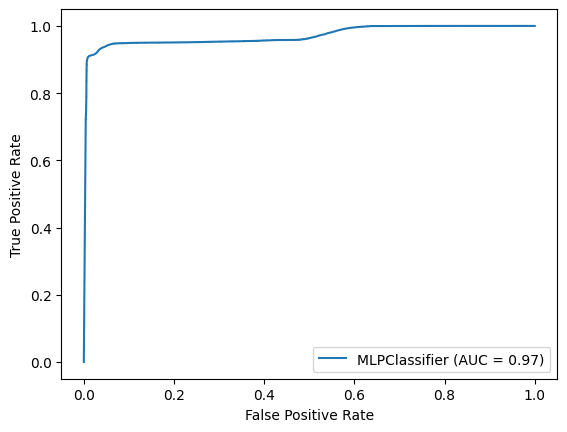

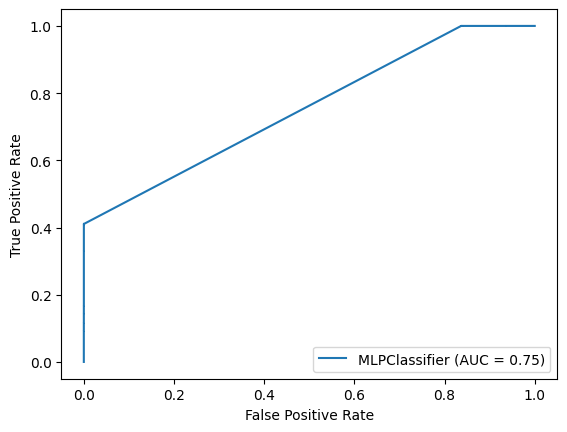

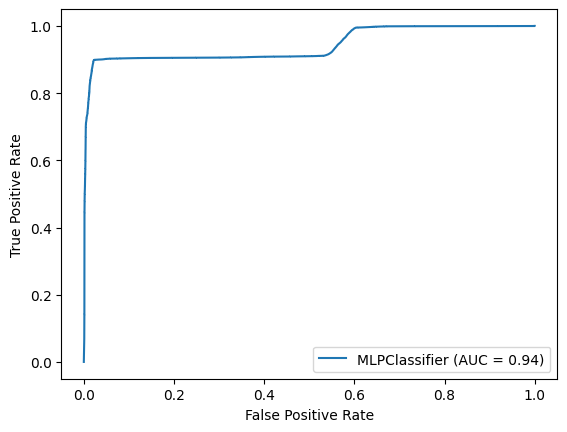

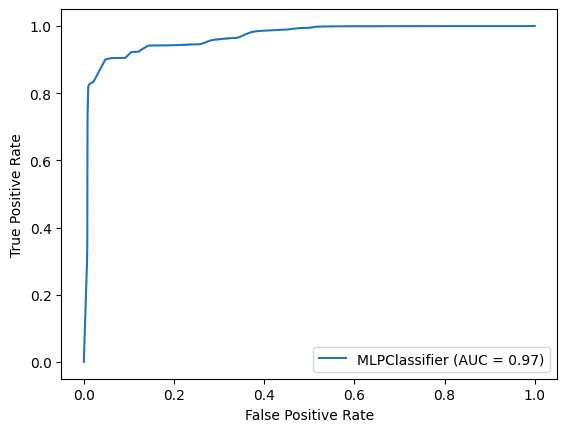

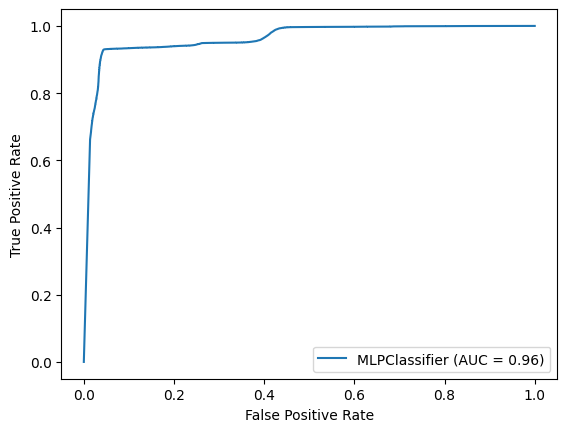

In [ ]:
print("Cross validating MLP")

fit_train = test_df_two.apply(LabelEncoder().fit_transform)

n_columns = len(fit_train.columns)
x = fit_train.iloc[:, :-1].values # Features
y = fit_train.iloc[:, n_columns-1].values # Labels

idx = 0
kf = StratifiedKFold(n_splits=5)

for train_index, test_index in kf.split(x, y):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  idx += 1
  print(f"Fold {idx}\n")


  classifier = MLPClassifier(hidden_layer_sizes=6)
  classifier.fit(x_train, y_train)
  y_pred = classifier.predict(x_test)

  print(confusion_matrix(y_test, y_pred))
  print(mean_absolute_error(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  plot_roc_curve(classifier, x_test, y_test)

# Considerações finais

Nos 3 métodos de classificação conseguimos resultados razoáveis. Analistando todos os métodos, podemos notar que existe uma disparidade entre os seus resultados.  
Analisando um a um temos:

**K-Nearest Neighbors (KNN):**  

  Verdadeiro Positivo - 155535 | Falso Negativo - 46769
  ------|------
  Falso Positivo - 199336 | Verdadeiro Negativo - 7789

DDoS - 44%  
Benigno - 14%  
Media de erro absoluta = 0.60

  
**Random Forests (RF):**    
  
  Verdadeiro Positivo - 202304 | Falso Negativo - 0
  ------|-------
  Falso Positivo - 207125 | Verdadeiro Negativo - 0   


DDoS - 49%
Benigno - 0%

Media de erro absoluta = 0.50


**Multilayer Perceptron (MLP):**

 Verdadeiro Positivo - 25813 | Falso Negativo - 176491
 ------|-------
 Falso Positivo - 579 | Verdadeiro Negativo -  206546

DDoS - 98%  
Benigno - 54%  
Media de erro absoluta = 0.43

Nos 3 testes realizados, notamos que a classificação de DDoS (Verdadeiros positivos) obteve maior precisão do que a classificação de Benignos, acreditos que isto se dá devido ao fato de haver mais dados DDoS do que Benignos. Apesar destes detalhes, o classificador MLP apresentou os melhores resultados, tanto para classificar DDos como para classificar Benignos.

Durante os testes de *cross-validation* notamos que os classificadores *KNN* e *RF* apresentaram resultados que dificilmente correspondem com a realidade, acreditamos que a causa desse problema é que podemos estar separando a base de dados incorretamente, misturando os dados de teste com dados de treino. 

Com os parâmetros testados, conseguimos identificar resultados razoáveis. Dentre os 3 classificadores, o MLP possuiu o resultado mais satisfatório.



## Problemas no decorrer do trabalho

1.   Campos com IP sendo mal interpretados
2.   Resultados errados para KNN
3.   Cross validation com resultado 100%
4.   Volume muito grande do dataset (6gb+)



## Soluções 

1.   Pré-processar o dataset com labelencoder obs: foi utilizado em todas as colunas, tentamos com apenas as colunas IP e obtivemos mais problemas. 
2.   O Resultados errados se davam por conta que estavamos utilizando a coluna FLOW ID que era unica e acabou prejudicando o aprendizado dos algoritmos.
3.   Verificamos a matriz de confusão para detectar falsos negativos e não constatamos isso, cross validation continua com 100%
4.   Tivemos que utilizar porcentagens equivalentes menores do dataset, pois com o volume total não estavamos conseguindo executar os algoritmos e avaliar os resultados. 



# Trabalhos futuros
Devido ao pouco tempo de desenvolvimento do trabalho, não foi possível confirmar a causa raíz do problema (apesar de termos uma suspeita), e desta forma como trabalho futuro seria implementar a correção de preparação dos dados para os testes.